In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import shap
from ucimlrepo import fetch_ucirepo 


/Users/start/opt/anaconda3/envs/shap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.Data Undestanding**

#### 1.1 Dataset Overview

In [3]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 

# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 


In [4]:
# Remove duplicate rows
combined = pd.concat([X, y], axis=1).drop_duplicates()

# Check for identical X with different y and remove them
inconsistent_indices = combined[combined.duplicated(subset=combined.columns[:-1], keep=False) & combined.duplicated(subset=[combined.columns[-1]], keep=False)].index
if not inconsistent_indices.empty:
    combined = combined.drop(inconsistent_indices)

# Separate features and target after cleaning
X = combined.iloc[:, :-1]
y = pd.DataFrame(combined.iloc[:, -1], columns=['Diabetes_binary'])

In [5]:
# 计算 Diet 列
X['Diet'] = X['Fruits'] + X['Veggies']

# 计算 cardiovascular 列
X['cardiovascular'] = X['HighChol'] + X['HighBP']

# 计算 unhealthy_behavior 列
X['unhealthy_behavior'] = X['Smoker'] + X['HvyAlcoholConsump']

# 计算 healthcare 列
X['healthcare'] = np.where(
    (X['AnyHealthcare'] == 1) & (X['NoDocbcCost'] == 0), 3,
    np.where((X['AnyHealthcare'] == 1) & (X['NoDocbcCost'] == 1), 2,
    np.where((X['AnyHealthcare'] == 0) & (X['NoDocbcCost'] == 0), 1,
    np.where((X['AnyHealthcare'] == 0) & (X['NoDocbcCost'] == 1), 0,
    -1))))



In [6]:
X[]

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diet,cardiovascular,unhealthy_behavior,healthcare
0,1,1,1,40,1,0,0,0,0,1,...,15,1,0,9,4,3,1,2,1,3
1,0,0,0,25,1,0,0,1,0,0,...,0,0,0,7,6,1,0,0,1,0
2,1,1,1,28,0,0,0,0,1,0,...,30,1,0,9,4,8,1,2,0,2
3,1,0,1,27,0,0,0,1,1,1,...,0,0,0,11,3,6,2,1,0,3
4,1,1,1,24,0,0,0,1,1,1,...,0,0,0,11,5,4,2,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,5,0,1,5,6,7,2,2,0,3
253676,1,1,1,18,0,0,0,0,0,0,...,0,1,0,11,2,4,0,2,0,3
253677,0,0,1,28,0,0,0,1,1,0,...,0,0,0,2,5,2,1,0,0,3
253678,1,0,1,23,0,0,0,0,1,1,...,0,0,1,7,5,1,2,1,0,3


In [10]:
features = ['HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'Stroke', 'CholCheck', 'BMI', 'Diet', 'cardiovascular', 'unhealthy_behavior','healthcare']
X_clean = X[features]

In [11]:
X_clean

,HeartDiseaseorAttack,PhysActivity,GenHlth,Stroke,CholCheck,BMI,Diet,cardiovascular,unhealthy_behavior,healthcare
0,0,0,5,0,1,40,1,2,1,3
1,0,1,3,0,0,25,0,0,1,0
2,0,0,5,0,1,28,1,2,0,2
3,0,1,2,0,1,27,2,1,0,3
4,0,1,2,0,1,24,2,2,0,3
...,...,...,...,...,...,...,...,...,...,...
253675,0,0,3,0,1,45,2,2,0,3
253676,0,0,4,0,1,18,0,2,0,3
253677,0,1,1,0,1,28,1,0,0,3
253678,0,0,3,0,1,23,2,1,0,3


In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_clean)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [17]:
# Reshape y_train and y_test to avoid DataConversionWarning
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [18]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_params = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)
lr_accuracy = accuracy_score(y_test, lr_grid.best_estimator_.predict(X_test))
print("Best Logistic Regression Params:", lr_grid.best_params_)
print("Logistic Regression Accuracy:", lr_accuracy)

Best Logistic Regression Params: {'C': 0.1, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.8557511763016634


In [19]:
# Decision Tree
dt = DecisionTreeClassifier()
dt_params = {'max_depth': [5, 10, 15, 20, None], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_accuracy = accuracy_score(y_test, dt_grid.best_estimator_.predict(X_test))
print("Best Decision Tree Params:", dt_grid.best_params_)
print("Decision Tree Accuracy:", dt_accuracy)

Best Decision Tree Params: {'max_depth': 5, 'min_samples_split': 2}
Decision Tree Accuracy: 0.8561046190549825


In [20]:
# Random Forest
rf = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_accuracy = accuracy_score(y_test, rf_grid.best_estimator_.predict(X_test))
print("Best Random Forest Params:", rf_grid.best_params_)
print("Random Forest Accuracy:", rf_accuracy)

Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Accuracy: 0.8575183900682586


In [21]:
# Gradient-Boosted Tree
gbt = GradientBoostingClassifier()
gbt_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
gbt_grid = GridSearchCV(gbt, gbt_params, cv=5, scoring='accuracy')
gbt_grid.fit(X_train, y_train)
gbt_accuracy = accuracy_score(y_test, gbt_grid.best_estimator_.predict(X_test))
print("Best GBT Params:", gbt_grid.best_params_)
print("GBT Accuracy:", gbt_accuracy)

Best GBT Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
GBT Accuracy: 0.858335726435309


In [ ]:
# Support Vector Machine
# svm = SVC()
# svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
# svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy')
# svm_grid.fit(X_train, y_train)
# svm_accuracy = accuracy_score(y_test, svm_grid.best_estimator_.predict(X_test))
# print("Best SVM Params:", svm_grid.best_params_)
# print("SVM Accuracy:", svm_accuracy)

In [22]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_accuracy = accuracy_score(y_test, nb.predict(X_test))
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.7960414411628267


In [23]:

# Neural Network (MLP)
mlp = MLPClassifier(max_iter=1000)
mlp_params = {'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]}
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy')
mlp_grid.fit(X_train, y_train)
mlp_accuracy = accuracy_score(y_test, mlp_grid.best_estimator_.predict(X_test))
print("Best MLP Params:", mlp_grid.best_params_)
print("MLP Accuracy:", mlp_accuracy)

Best MLP Params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
MLP Accuracy: 0.8579160131657425


In [32]:
# 存储模型的准确度以及模型本身
accuracies = {
    'Logistic Regression': (lr_accuracy, lr_grid.best_estimator_),
    'Decision Tree': (dt_accuracy, dt_grid.best_estimator_),
    'Random Forest': (rf_accuracy, rf_grid.best_estimator_),
    'Gradient-Boosted Tree': (gbt_accuracy, gbt_grid.best_estimator_),
    # 'Support Vector Machine': (svm_accuracy, svm_grid.best_estimator_),
    # 'Naive Bayes': (nb_accuracy),
    'Neural Network (MLP)': (mlp_accuracy, mlp_grid.best_estimator_)
}

# 获取最佳模型名称和实际模型
best_model_name = max(accuracies, key=lambda x: accuracies[x][0])
best_model_accuracy, best_model = accuracies[best_model_name]
print("Best Model:", best_model_name, "with Accuracy:", best_model_accuracy)

# 根据模型类型选择合适的 SHAP explainer
if best_model_name in ['Random Forest', 'Gradient-Boosted Tree', 'Decision Tree']:
    explainer = shap.TreeExplainer(best_model)
elif best_model_name in ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes']:
    explainer = shap.LinearExplainer(best_model, X_train)
elif best_model_name == 'Neural Network (MLP)':
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train)


Best Model: Gradient-Boosted Tree with Accuracy: 0.858335726435309


In [38]:
X_test_df = pd.DataFrame(X_test, columns=X_clean.columns)


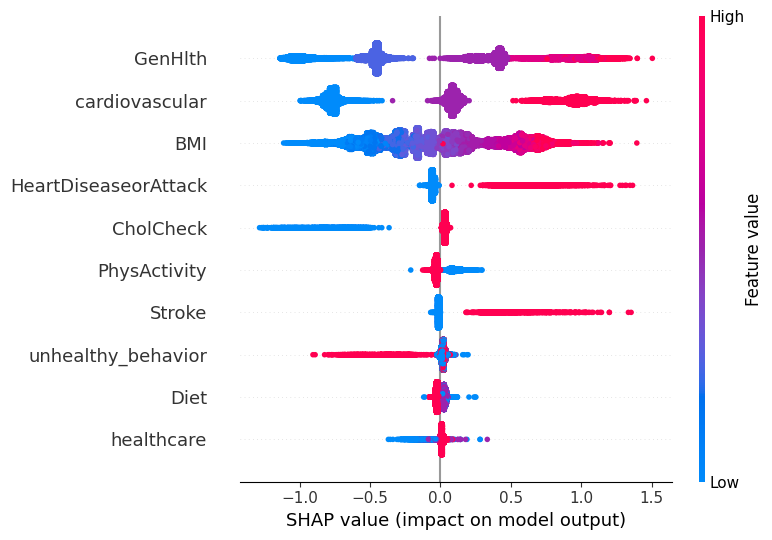

In [40]:
# 确保在 SHAP 可视化中使用 DataFrame
shap_values = explainer.shap_values(X_test_df)

# 使用 SHAP 可视化，并确保特征名称显示在图上
shap.summary_plot(shap_values, X_test_df, feature_names=X_clean.columns)